In [1]:
import numpy as np
import pandas as pd

import contractions
import re
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

from src.features.build_features import preprocess_text, lemmatize_with_postags, remove_missing_reviews
from src.utilities.utilities import text_statistics, token_statistics

from pandarallel import pandarallel
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()
pandarallel.initialize()

/usr/local/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# setting some CONSTANTs
plt.style.use(['science'])
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",   # specify font family here
    "font.serif": ["Palatino"],  # specify font here
    "font.size":12})

# Exploratory Text Pre-processing

In [3]:
CATEGORY = "Grocery_and_Gourmet_Food"

In [4]:
# load dataset
products = pd.read_csv(f"data/interim/{CATEGORY}_merged.csv")

# check first 5 rows
products.head()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime
0,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A23RYWDS884TUL,5.0,This curry paste makes a delicious curry. I j...,"05 28, 2013"
1,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A945RBQWGZXCK,5.0,I've purchased different curries in the grocer...,"09 17, 2012"
2,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A1TCSC0YWT82Q0,5.0,I love ethnic foods and to cook them. I recent...,"08 3, 2013"
3,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3AMNY44OP8AOU,4.0,I started a new diet restricting all added sug...,"01 23, 2014"
4,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3IB4CQ2QEJLJ8,5.0,So many flavors. I can't begin to tell you how...,"04 27, 2014"


## 1. Review Text Characteristics

### What is the min/max and average review length?

In [5]:
text_statistics(products, 'reviewText')

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 18801 characters, 3368 words.
Mean `reviewText` length: 502.79 characters, 91.84 words.
Median `reviewText` length: 347.0 characters, 64.0 words.


## 2. Text Pre-processing

### Expanding Contractions

In [6]:
products["processedReviewText"] = products["reviewText"].parallel_apply(lambda x: contractions.fix(x))

In [7]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 18916 characters, 3459 words.
Mean `reviewText` length: 505.10 characters, 93.45 words.
Median `reviewText` length: 349.0 characters, 66.0 words.


In [8]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['I occasionally like to add a little flavor to my club soda or mineral water & this gives me a healthy choice. For me it is very sweet, because I really restrict my carb intake. It only takes a couple of drops in a 16 oz. bottle of water, to satisfy me.', "I enjoy a variety of coffees, especially espresso made with Italian beans like Lavazza, and I find the flavor to this smooth and pleasant.  I see that a lot of people did not like the flavor to this and I wonder if it is because it does not have the regular kind of sweet Starbucks flavoring.  A lot of those drinks have a lot of sugar and flavorings in them.And I HAVE learned that apparently this has some sneaky sugar in it from reading Jenn's review.  that is really a shame.That is why this review is 4 stars instead of 5.  I do not look at that info carefully enough so I was lulled into complacency.  90 calories is like a free lunch.I have ALSO learned that apparently people got a much better deal on this than I EVER did.  I usually

### Removing Special Characters

In [9]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: " ".join(str(x).splitlines()))
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: re.sub(r"[^a-zA-Z]+", ' ', x.lower()))

In [10]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 17928 characters, 3399 words.
Mean `reviewText` length: 487.98 characters, 94.21 words.
Median `reviewText` length: 338.0 characters, 66.0 words.


In [11]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['i collect teas i have soooo many my favorite though is stinky tea or earl grey this cardamom pu erh tea is just like a mild earl grey if you like eg you will enjoy this tea very much if you do not you probably will not like this it is very strong at first sniff but after you brew it it becomes a relatively mild gentle tea i enjoyed it five stars ', 'a w e s o m e and guiltless to boot i am ordering more this season ', 'do not under estimate the appeal of salt and cayenne red pepper for many soup lovers and reviewers that includes me i certainly like this soup but i am under no illusions it is far from healthy and it only has two flavors candidly this is nothing more than a watery noodle soup with lots of red pepper and a tremendous amount of salt if you add an egg it can taste even better chop up some scallion and it further improves there is nothing terribly impressive about this soup yet as i said i like it this dry soup mix consists of a large packet of noodles essentially tastele

### Lower Case

In [12]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: x.lower())

In [13]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 17928 characters, 3399 words.
Mean `reviewText` length: 487.98 characters, 94.21 words.
Median `reviewText` length: 338.0 characters, 66.0 words.


In [14]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['i made these yesterday for me and my husband i am so glad i found these i added a really good vanilla to the mix then i added chopped pecans and a small amount of mini semi sweet chocolate chips enjoy life non dairy non nuts non soy as i am not big on chocolate i love the fact that this mix includes brown sugar which is in keeping with the recipe i used prior to going gluten free i think i have lost all self control with these i made these last night and there are very few remaining it is probably because i have found something regular i can eat without fear of repercussions would make this for a mixed audience gluten free non gf the only con about this mix is that it is a bit salty ', 'this is a good tasting tea but needs to be steeped for awhile or it is a bit weak i think the perfect energy is a bit of a stretch since there are so many variables to whether or not this will help your energy level it does have caffiene so if caffiene does anything for you it might boost your energy 

### Lemmatization

In [15]:
def lemmatize_with_postags(sentence):
    """Lemmatize a given sentence based on given POS tags.
        Ref: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#comparingnltktextblobspacypatternandstanfordcorenlp

    Args:
        sentence ([type]): [description]

    Returns:
        [type]: [description]
    """
    sent = TextBlob(sentence)
    tag_dict = {"J": "a", "N": "n", "V": "v", "R": "r"}
    words_and_tags = [(w, tag_dict.get(pos[0], "n")) for w, pos in sent.tags]
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]

    return " ".join(lemmatized_list)

In [16]:
%%time
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: lemmatize_with_postags(x))

CPU times: user 170 ms, sys: 222 ms, total: 392 ms
Wall time: 1min 51s


In [17]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 17273 characters, 3400 words.
Mean `reviewText` length: 470.50 characters, 94.29 words.
Median `reviewText` length: 325.0 characters, 66.0 words.


In [18]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['i like seaweed soup and just love the same product from san j also available from amazon get it it be star this miso cup brand be terrible i can not tell you more than this be just yicky wish there be a zero star rating i do not finish the first cup even but do give it a second try the next day with same result therefore i only use one serve envelope before give away the rest oh why do i stray from san j actually i think it might be worth try miso cup s different flavor to add variety to my afternoon broth experience but all the miso cup be equally dreadful i give these and the other miso cup box to a food pantry but i tell them first why to warn others it might not suit them get the san j brand', 'this tea burst with fruity flavor in your mouth with each swallow while it be not my favorite for wake up in the morning or calm down before bed at night it be a great mid day tea to put a little pep in the day', 'this magnolia puerh and green tea blend be surprisingly smooth and easy to b

### Remove Stop Words

In [19]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: remove_stopwords(x))

In [20]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 9424 characters, 1433 words.
Mean `reviewText` length: 257.16 characters, 39.82 words.
Median `reviewText` length: 173.0 characters, 27.0 words.


In [21]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['company use cheap product chinathat poisen remember veggie booty recall year ago plus product healthy real', 'adamant lover coffeehouse peppermint mochas need cold want nice hot cup chocolate cool edge peppermint look package peppermint cocoa syrups adore york s peppermint patty expectation peppermint chocolate international coffee buy occasion added shot normal brew coffee home like add flavor spike plain brew bit energy like add shot espresso douse cup sugar cream like coffee smooth sweet normal use mind purchase item try stand test couple spoonful powder cup add brewed coffee heat milk pour powder use hot water cocoa sure use brew coffee mix nice strong sweet peppermint taste dark edge chocolate flavor know brewed coffee bring chocolate bit happy lose peppermint mix smell carry lot mint little disappointing hop scent taste experience peppermint mocha spike heated milk produce sweet cup lose coffee flavor honestly end taste like decent cup peppermint hot cocoa instead mocha start r

### Tokenization

In [22]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: simple_preprocess(x, deacc=True))

In [23]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

[['pleased', 'tahini', 'al', 'wadi', 'jar', 'arrive', 'okay', 'plastic', 'wrap', 'jar', 'little', 'greasy', 'touch', 'wash', 'away', 'little', 'warm', 'water', 'soap', 'unopened', 'believe', 'jar', 'store', 'unrefrigerated', 'refrigerate', 'safe', 'use', 'tahini', 'mainly', 'hummus', 'work', 'awesome', 'spread', 'falafel', 'tahini', 'food', 'processor', 'lemon', 'juice', 'couple', 'garlic', 'clove', 'cold', 'water', 'mint', 'leaf'], ['great', 'single', 'cup', 'maker', 'keurig', 'mr', 'coffee', 'cup', 'maker'], ['foolish', 'dumb', 'sound', 'forget', 'impact', 'caffeine', 'health', 'issue', 'primarily', 'raise', 'ocular', 'pressure', 'glaucoma', 'medical', 'eye', 'issue', 'new', 'job', 'new', 'pressure', 'stress', 'longer', 'hour', 'inclement', 'weather', 'brew', 'coffee', 'refill', 'big', 'travel', 'mug', 'think', 'use', 'high', 'quality', 'coffee', 'read', 'article', 'organic', 'high', 'quality', 'coffee', 'affect', 'affect', 'actual', 'caffeine', 'component', 'felt', 'okay', 'drink', 

### Combining Tokens Into Pre-processed Reviews

In [24]:
products["processedReviewText"] = products["processedReviewText"].parallel_apply(lambda x: ' '.join(x))

In [25]:
# check statistics
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 0 characters, 0 words.
Maximum `reviewText` length: 9385 characters, 1423 words.
Mean `reviewText` length: 255.96 characters, 39.32 words.
Median `reviewText` length: 172.0 characters, 27.0 words.


In [26]:
print([i for i in products.sample(25)["processedReviewText"].values.tolist()])

['tinkyada product use fabulous fact hard state good try wheat pasta past bitter try husband stop ask white flour pasta', 'buy product local costco cheap price live work desolate place amazon deliver costco pay amazon asking price exact bottle mexican coca cola good bother drink regular soda high fructose corn syrup fast food restaurant day order bottle apple juice endure spectacular taste american coke high fructose corn syrup stand taste regular soda anymore run bottle mexican coke trip costco soda costco rate product absolute star', 'tasty reason star price somewhat high retailer', 'cappuccino drinker sweet drink like product delightful change straight coffee hot chocolate wish partially hydrogenate vegetable oil corn syrup solid feel like eat right drink', 'buy gift daughter work lunch complaint heard purchase right price easy open', 'hot cocoa product super yummy milk sugar add add coffee like overall good quality', 'love product love eat frost shredded wheat usually sweet lightly

### Removing Empty Reviews

Post pre-processing, we observed that the minimum characters and words of a review is 0. This indicates some reviews which are short to begin with, will get pruned after the series of pre-processing. Hence, we will remove such reviews.

In [27]:
products = remove_missing_reviews(products, "processedReviewText")

In [28]:
text_statistics(products, "processedReviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 9385 characters, 1423 words.
Mean `reviewText` length: 255.96 characters, 39.32 words.
Median `reviewText` length: 172.0 characters, 27.0 words.


In [29]:
# check shape
print(f"Rows: {products.shape[0]}, Columns: {products.shape[1]}.")

Rows: 77602, Columns: 10.


In [30]:
# check last 5 rows and their index
products.tail()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,reviewCharLength,reviewWordLength,processedReviewText
77597,B00KCJRVO2,"Chex Gluten Free Oatmeal Variety Pack, 8.84 Ounce","['Grocery & Gourmet Food', 'Breakfast Foods', ...",A2L6QS8SVHT9RG,4.0,Delicious gluten-free oatmeal: we tried both t...,"07 12, 2014",305,41,delicious gluten free oatmeal try regular plai...
77598,B00KCJRVO2,"Chex Gluten Free Oatmeal Variety Pack, 8.84 Ounce","['Grocery & Gourmet Food', 'Breakfast Foods', ...",AFJFXN42RZ3G2,4.0,With the many selections of instant oatmeal ce...,"07 6, 2014",508,77,selection instant oatmeal cereal produce choos...
77599,B00KCJRVO2,"Chex Gluten Free Oatmeal Variety Pack, 8.84 Ounce","['Grocery & Gourmet Food', 'Breakfast Foods', ...",ASEBX8TBYWQWA,5.0,"While I usually review CDs and DVDs, as well a...","07 1, 2014",1065,158,usually review cd dvd entertainment relate boo...
77600,B00KCJRVO2,"Chex Gluten Free Oatmeal Variety Pack, 8.84 Ounce","['Grocery & Gourmet Food', 'Breakfast Foods', ...",ANKQGTXHREOI5,4.0,My son and I enjoyed these oatmeal packets. H...,"07 4, 2014",338,47,son enjoy oatmeal packet fond maple brown suga...
77601,B00KCJRVO2,"Chex Gluten Free Oatmeal Variety Pack, 8.84 Ounce","['Grocery & Gourmet Food', 'Breakfast Foods', ...",A2CF66KIQ3RKX3,4.0,I like to eat oatmeal i the mornings. I usuall...,"07 11, 2014",259,39,like eat oatmeal morning usually buy quaker oa...


# Pre-processing Demonstration

In [31]:
# load dataset
products_demo = pd.read_csv(f"data/interim/{CATEGORY}_merged.csv")

# check first 5 rows
products_demo.head()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime
0,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A23RYWDS884TUL,5.0,This curry paste makes a delicious curry. I j...,"05 28, 2013"
1,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A945RBQWGZXCK,5.0,I've purchased different curries in the grocer...,"09 17, 2012"
2,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A1TCSC0YWT82Q0,5.0,I love ethnic foods and to cook them. I recent...,"08 3, 2013"
3,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3AMNY44OP8AOU,4.0,I started a new diet restricting all added sug...,"01 23, 2014"
4,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3IB4CQ2QEJLJ8,5.0,So many flavors. I can't begin to tell you how...,"04 27, 2014"


In [32]:
n_random_products = products_demo.sample(10)

In [33]:
n_random_products["processedReviewText"] = n_random_products["reviewText"].progress_apply(lambda x: preprocess_text(x))

100%|██████████| 10/10 [00:01<00:00,  7.59it/s]


In [34]:
n_random_products

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,processedReviewText
41811,B002D4DY8G,"Gevalia Dark Chocolate Truffle Ground Coffee, ...","['Grocery & Gourmet Food', 'Beverages', 'Coffe...",A35Q0RBM3YNQNF,3.0,I brewed the Gevalia Dark Chocolate Truffle co...,"11 25, 2009",brew gevalia dark chocolate truffle coffee cui...
72005,B00B18PAWI,"Nestle Skinny Cow Divine Filled Chocolates, Ca...","['Grocery & Gourmet Food', 'Food & Beverage Gi...",A184ZFZZBWEXMS,5.0,I was pleasantly surprised upon taking my firs...,"03 28, 2013",pleasantly surprise bite expect calorie good s...
42345,B002EDDA2Q,"REESE'S Peanut Butter Cups, Dark Chocolate Can...","['Grocery & Gourmet Food', 'Candy & Chocolate'...",A2V06LQMT0FEFX,5.0,"Dark Chocolate Peanut Butter Cups Are So Good,...","05 17, 2014",dark chocolate peanut butter cup good eat fami...
76151,B00DUW79Y0,Snack Pack Chocolate and Butterscotch Pudding ...,"['Grocery & Gourmet Food', 'Cooking & Baking',...",A3H21IVDHN0WHN,4.0,"Excellent quality, but too pricey. Will power...","07 12, 2014",excellent quality pricey power need eat portio...
35381,B001O8PSRW,Arrowhead Mills Organic Yellow Popcorn - 28 oz,"['Grocery & Gourmet Food', 'Snack Foods', 'Pop...",ACMWFQ6ZUUCQG,5.0,Hardly a widow in any batch. Very large and p...,"12 21, 2012",hardly widow batch large puffy pop little pric...
57918,B0051NHI6U,"Rodelle Organics Pure Vanilla Extract-Bourbon,...","['Grocery & Gourmet Food', 'Cooking & Baking']",A10J8E7PWBODL7,5.0,Ionly eat organic now and find that flavor is ...,"04 3, 2014",ionly eat organic flavor important guess lack ...
67677,B007JHXQQC,"Vita Coco Caf&eacute; Latte, Original, 11.1 Ou...","['Grocery & Gourmet Food', 'Beverages', 'Bottl...",A1YCCRVPH18GQR,5.0,This is my favorite coconut water. It's so yum...,"08 18, 2013",favorite coconut water yummy love taste like i...
60589,B005IW4WEA,"KIND Healthy Grains Clusters, Peanut Butter Wh...","['Grocery & Gourmet Food', 'Breakfast Foods', ...",AFDJGY68CQL2X,4.0,"I was excited to try this cereal, and when I e...","11 15, 2011",excite try cereal eat granola like plain sligh...
54678,B004OP74HE,Nature Valley Granola Thins Crispy Squares - D...,"['Grocery & Gourmet Food', 'Snack Foods', 'Bars']",AHRNDSKWH1YBT,5.0,I love to have one of these after lunch at wor...,"01 23, 2012",love lunch work quick grab snack errand kid lu...
26736,B001E5E1MI,"Nutiva Organic, Cold-Pressed, Unrefined, Virgi...","['Grocery & Gourmet Food', 'Cooking & Baking',...",A3KZLIEGCSSM5L,4.0,Jarrow EVCO is becoming too expensive but othe...,"08 21, 2011",jarrow evco expensive brand price range fell s...


In [35]:
print("Review text pre-processing, before vs. after: ")
before = n_random_products["reviewText"].values.tolist()
after = n_random_products["processedReviewText"].values.tolist()

for i in zip(before, after):
    print(f"Before: {i[0]}")
    print(f"After: {i[1]}\n")

Review text pre-processing, before vs. after: 
Before: I brewed the Gevalia Dark Chocolate Truffle coffee both in a Cuisinart automatic brew coffee maker and a french press. I followed the instructions on the package - 1 rounded tablespoon for each 6 ounce cup of coffee. I found the same taste results with both methods. I like a good cup of black coffee but am not fanatical about it. I do grind fresh bold or medium body beans each morning and use filtered water to prepare the pot.As someone who usually adds a little espresso or instant espresso powder to most chocolate recipes I know this flavor combination is a wonderful marriage. Depending on the percentage of espresso to chocolate, the result is either a deep mocha flavor with the coffee playing a major role, or a small addition will result in complex chocolate flavor with no obvious coffee component.  Unfortunately, with the Gevalia Dark Chocolate Truffle coffee the merger of coffee and chocolate adversely affected both the coffee 

# Data Visualization

In [36]:
text_statistics(products, "reviewText")

Text statistics:

Minimum `reviewText` length: 2 characters, 1 words.
Maximum `reviewText` length: 18801 characters, 3368 words.
Mean `reviewText` length: 502.80 characters, 91.84 words.
Median `reviewText` length: 347.0 characters, 64.0 words.


In [37]:
products.head()

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,reviewCharLength,reviewWordLength,processedReviewText
0,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A23RYWDS884TUL,5.0,This curry paste makes a delicious curry. I j...,"05 28, 2013",209,36,curry paste delicious curry fry chicken vegeta...
1,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A945RBQWGZXCK,5.0,I've purchased different curries in the grocer...,"09 17, 2012",314,57,purchase different curry grocery store complet...
2,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A1TCSC0YWT82Q0,5.0,I love ethnic foods and to cook them. I recent...,"08 3, 2013",510,98,love ethnic food cook recently purchase produc...
3,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3AMNY44OP8AOU,4.0,I started a new diet restricting all added sug...,"01 23, 2014",272,52,start new diet restrict added sugar brand suga...
4,9742356831,"Mae Ploy Green Curry Paste, 14 oz","['Grocery & Gourmet Food', 'Sauces, Gravies & ...",A3IB4CQ2QEJLJ8,5.0,So many flavors. I can't begin to tell you how...,"04 27, 2014",554,112,flavor begin tell love mae ploy curry ask reci...


In [38]:
products["processedReviewWordLength"] = products["processedReviewText"].apply(lambda x: len(x.split()))

In [39]:
def plot_distributions(df, cols=['reviewWordLength', 'processedReviewWordLength']):
    fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
    fig.suptitle(f"Comparison of Review Words Distribution Before and After Pre-processing", y=0.925, verticalalignment='bottom')
    for idx, col in enumerate(cols):
        ax = sns.histplot(df[col], ax=axes[idx], bins=100, binwidth=10)
        ax.set_xlim(0,500)
    
    plt.savefig(f"reports/figures/review_words_distribution.png", dpi=150)
    plt.show()

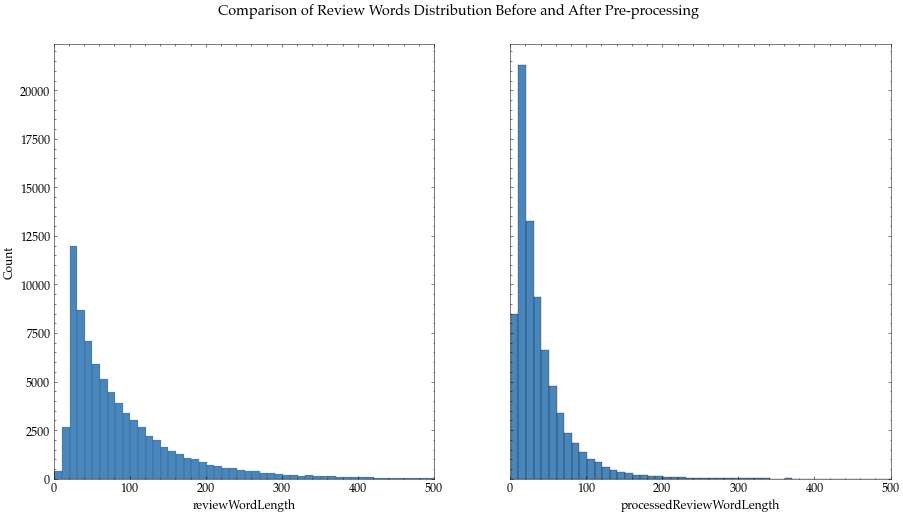

In [40]:
plot_distributions(products)

In [41]:
products.sort_values(by='processedReviewText', ascending=True, key=lambda x: x.str.len())

,asin,title,categories,reviewerID,overall,reviewText,reviewTime,reviewCharLength,reviewWordLength,processedReviewText,processedReviewWordLength
70387,B0098WV8F2,Bell Plantation PB2 Powdered Peanut Butter and...,"['Grocery & Gourmet Food', 'Jams, Jellies & Sw...",A3W1L4XPSAUK0M,5.0,Ok!,"07 10, 2014",3,1,ok,1
19694,B0010UOGWM,"SodaStream Diet Ginger Ale Syrup, 500mL","['Grocery & Gourmet Food', 'Beverages', 'Bottl...",A2GJ8E2JIJW08E,3.0,Ok,"07 2, 2014",2,1,ok,1
25670,B001E52YY0,"Old Wisconsin Turkey Sausage Snack Bites, 8-O...","['Grocery & Gourmet Food', 'Snack Foods', 'Jer...",A30ZJ9OT34RI8P,3.0,it was ok,"07 5, 2014",9,3,ok,1
72509,B00BFM6OAW,"Kind Peanut Butter Dark Chocolate+ Protein, 1....","['Grocery & Gourmet Food', 'Snack Foods']",A3PADOH71NGT71,4.0,this was ok,"07 5, 2014",11,3,ok,1
64751,B006H3BFQM,SeaSnax Seaweed Snk Chptle 5Ct 0.54Oz Seaweed ...,"['Grocery & Gourmet Food', 'Snack Foods', 'Sea...",A3CP9LMG5SM5KK,5.0,"YUM, but $$$","07 7, 2014",12,3,yum,1
...,...,...,...,...,...,...,...,...,...,...,...
47358,B003ULJIP4,"Numi Organic Tea Numi's Collection, Assorted F...","['Grocery & Gourmet Food', 'Beverages', 'Coffe...",A3PUQVVX2QGBOP,5.0,Having decided to give coffee a rest for a whi...,"01 4, 2014",11308,1985,decide coffee rest tea honest effort decide pu...,914
7696,B000EMAZPO,"Lipton Black Tea, Black Pearl Pure Long Leaf 2...","['Grocery & Gourmet Food', 'Beverages', 'Coffe...",A28P0QPSXBJTN,4.0,Lipton Black Pearl Tea. Ahhhh. Now only a bl...,"08 18, 2010",10889,1829,lipton black pearl tea ahhhh bloody fool equat...,935
28343,B001ELL288,"Eden Selected Dried Montmorency Cherries, 4-Ou...","['Grocery & Gourmet Food', 'Produce', 'Dried F...",A3RR2P5IS3DGPR,5.0,These Eden Dried Montmorency Cherries are perf...,"06 11, 2010",9736,1468,eden dry montmorency cherry perfection delicio...,865
68282,B007TGO1TY,"NECTRESSE Natural No Calorie Sweetener, 140 Se...","['Grocery & Gourmet Food', 'Cooking & Baking',...",A2VW4FYZILSXF2,4.0,PROS:Very nearly like sugarWorks great in cold...,"07 15, 2012",12052,1992,pro nearly like sugarworks great cold beverage...,927


In [42]:
# finding unique tokens for `preprocessedReviewText`
concat_tokens = ' '.join(products["processedReviewText"])
unique_tokens = len(set(concat_tokens.split()))
print(f"The number of unique tokens: {unique_tokens}")

The number of unique tokens: 43611


In [48]:
# finding unique tokens for `reviewText`
concat_tokens = ' '.join(products["reviewText"])
unique_tokens = len(set(concat_tokens.split()))
print(f"The number of unique tokens: {unique_tokens}")

The number of unique tokens: 230912


## Misc Test

In [43]:
review = products_demo.sample(1)['reviewText'].values[0]
print(review)

This product cleaned my cook top very well. The cleaning pads are easy on/easy off, and can also be used without the handle for those hard to reach areas. I was surprised to see how much gunk the cleaner took off. The cleaning pads come in a resealable pouch of six.Be advised, it doesn't matter what cleaner is used, if there is burnt-on gunk on the cook top, it's going to take some elbow grease to get it off. The handle that is used with the pads helps with heavier cleaning.There's all kinds of cook top cleaners on the market, but for ease and comfort of use, I really like this one.


In [44]:
review = lemmatize_with_postags(review)
print(review)

This product clean my cook top very well The cleaning pad be easy on/easy off and can also be use without the handle for those hard to reach area I be surprise to see how much gunk the clean take off The cleaning pad come in a resealable pouch of six.Be advise it do n't matter what cleaner be use if there be burnt-on gunk on the cook top it 's go to take some elbow grease to get it off The handle that be use with the pad help with heavy cleaning.There 's all kind of cook top cleaner on the market but for ease and comfort of use I really like this one


In [45]:
review = simple_preprocess(review, deacc=True)
print(review)

['this', 'product', 'clean', 'my', 'cook', 'top', 'very', 'well', 'the', 'cleaning', 'pad', 'be', 'easy', 'on', 'easy', 'off', 'and', 'can', 'also', 'be', 'use', 'without', 'the', 'handle', 'for', 'those', 'hard', 'to', 'reach', 'area', 'be', 'surprise', 'to', 'see', 'how', 'much', 'gunk', 'the', 'clean', 'take', 'off', 'the', 'cleaning', 'pad', 'come', 'in', 'resealable', 'pouch', 'of', 'six', 'be', 'advise', 'it', 'do', 'matter', 'what', 'cleaner', 'be', 'use', 'if', 'there', 'be', 'burnt', 'on', 'gunk', 'on', 'the', 'cook', 'top', 'it', 'go', 'to', 'take', 'some', 'elbow', 'grease', 'to', 'get', 'it', 'off', 'the', 'handle', 'that', 'be', 'use', 'with', 'the', 'pad', 'help', 'with', 'heavy', 'cleaning', 'there', 'all', 'kind', 'of', 'cook', 'top', 'cleaner', 'on', 'the', 'market', 'but', 'for', 'ease', 'and', 'comfort', 'of', 'use', 'really', 'like', 'this', 'one']


In [46]:
review_gensim = remove_stopwords(" ".join(review))
print(review_gensim)

product clean cook cleaning pad easy easy use handle hard reach area surprise gunk clean cleaning pad come resealable pouch advise matter cleaner use burnt gunk cook elbow grease handle use pad help heavy cleaning kind cook cleaner market ease comfort use like


In [47]:
review_nltk = " ".join([word for word in review if not word in stopwords.words()])
print(review_nltk)

product clean cook top well cleaning pad easy easy use without handle hard reach area surprise see much gunk clean cleaning pad resealable pouch six advise matter cleaner use burnt gunk cook top go elbow grease get handle use pad help heavy cleaning kind cook top cleaner market ease comfort use really like
